# Base Line + PCA

In [1]:
# base
import pandas as pd
import numpy as np
from datetime import datetime
import time
import random
from collections import Counter
import collections

# word2vec
from gensim.models.word2vec import Word2Vec

# error
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
    
# accuracy measure
from sklearn import *
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

# param search
from sklearn.model_selection import *

# training and testing data split
from sklearn.model_selection import *

# Boosting Model
from sklearn.ensemble import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# model save
import pickle
from sklearn.externals import *

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='nanumgothic')
plt.rc('axes', unicode_minus=False)
sns.set(style='white', context='notebook', palette='deep')
import seaborn as sns
%matplotlib inline


# Neural
from keras import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import *
from keras.optimizers import *

# PCA
from sklearn.decomposition import PCA

Using TensorFlow backend.


In [2]:
# load data & concat
tr_train = pd.read_csv('X_train.csv', encoding='cp949')
tr_test = pd.read_csv('X_test.csv', encoding='cp949')
tr = pd.concat([tr_train, tr_test])

In [3]:
# 당일판매금액 = 판매금액 / 할부개월수
tr['real_amt']= tr.tot_amt / tr.inst_mon

# 할인율 = (할인금액 / 판매금액) * 100
tr['dist_rate'] = (tr['dis_amt']/tr['tot_amt'])*100

# 판매날짜
tr.loc[456697,"sales_time"] = 1530
tr['sdate'] = tr.sales_date.str[:10]

# 판매시간
tr["time"] = tr['sdate'].astype(str).str.cat(tr["sales_time"].astype(str), sep =" ")
tr["time"] = pd.to_datetime(tr.time, format='%Y-%m-%d %H%M')

## 1. Feature Engineering

### 1.1 Baseline

In [4]:
features = []

In [5]:
# 평균할인율
df = tr.groupby('custid')['dist_rate'].agg([('평균할인율', 'mean')]).reset_index()
features.append(df)

# 평균구매시간
df = tr.groupby(['custid'])['sales_time'].agg([('평균구매시간대', 'mean')]).reset_index()
features.append(df)

# 평균할인금액
df = tr.groupby('custid')['dis_amt'].agg([('평균할인금액', 'mean')]).reset_index()
df.iloc[:,1] = df.iloc[:,1].apply(round, args=(1,))
features.append(df)

# 평균쇼핑시간
df = tr.groupby(['sdate','custid'])['time'].agg([('time', ['min','max'])]).reset_index()
df['shopping_time'] = (df['time']['max'] - df['time']['min']).dt.total_seconds()
df.drop(['sdate','time'], axis=1, inplace=True,level=0)
df = df.groupby(['custid'])['shopping_time'].agg([('평균쇼핑시간','mean')]).reset_index()
features.append(df)

# 평균구매가격
df = tr.groupby('custid')['tot_amt'].agg([('평균구매가격', 'mean')]).reset_index()
features.append(df)

# 평균할부개월수
df = tr.groupby('custid')['inst_mon'].agg([('평균할부개월수', 'mean')]).reset_index()
df.iloc[:,1] = df.iloc[:,1].apply(round, args=(1,))
features.append(df)

# 일평균구매건수
df = tr.groupby(['sales_date','custid'])['custid'].agg([('day_visit', 'count')]).reset_index()
df = df.groupby(['custid'])['day_visit'].agg([('일평균구매건수', 'mean')]).reset_index()
features.append(df)

# 일평균구매액
df = tr.groupby(['sales_date','custid'])['tot_amt'].agg([('day_amt', 'sum')]).reset_index()
df = df.groupby(['custid'])['day_amt'].agg([('일평균구매액', 'mean')]).reset_index()
features.append(df)

# 남성파트 구매비율
df = tr.groupby(['custid','part_nm'])['tot_amt'].agg([('tot_amt_part', 'sum')]).reset_index()
df['part_nm'] = np.where(df.part_nm.str.contains('남성'), '남성', '여성')
df = df.pivot_table(values='tot_amt_part', index=df.custid, columns='part_nm', aggfunc='first',fill_value=0).reset_index()
df['남성파트구매비율'] = (df['남성'] / (df['남성'] + df['여성'])) * 100
df = df.fillna(0)
features.append(df.iloc[:,[0,-1]])

# 화장품구매비율 
df = tr.groupby(['custid','corner_nm'])['tot_amt'].agg([('tot_amt_corner', 'sum')]).reset_index()
df['corner_nm'] = np.where(df.corner_nm.str.contains('화장품'), '화장품', '비화장품')
df = df.pivot_table(values='tot_amt_corner', index=df.custid, columns='corner_nm', aggfunc='first',fill_value=0).reset_index()
df['화장품비율'] = (df['화장품'] / (df['화장품'] + df['비화장품'])) * 100
df = df.fillna(0)
features.append(df.iloc[:,[0,-1]])

# 수입상품구매비율
x = tr[tr['import_flg'] == 1].groupby('custid').size() / tr.groupby('custid').size()
df = x.reset_index().rename(columns={0: '수입상품구매비율'}).fillna(0)
df.iloc[:,1] = (df.iloc[:,1]*100).apply(round, args=(1,))
features.append(df)

# 할부대비평균실구매액
df = tr.groupby('custid')['real_amt'].agg([('할부대비평균실구매', 'mean')]).reset_index()
features.append(df)

# 수입상품 구매총액
df = tr.groupby(['custid'])['import_flg'].agg([('수입상품구매총액', 'sum')]).reset_index()
features.append(df)

# 마지막거래후경과일
df = tr.groupby(['custid'])['sales_date'].agg([('sales_date', 'max')]).reset_index()
df['마지막거래후경과일'] = (pd.to_datetime(df.sales_date) - pd.to_datetime(tr.sales_date.min())).dt.days
features.append(df.iloc[:,[0,-1]])

# 총구매액
df = tr.groupby('custid')['tot_amt'].agg([('총구매액', 'sum')]).reset_index()
features.append(df)

# 총구매건수
df = tr.groupby('custid')['tot_amt'].agg([('총구매건수', 'size')]).reset_index()
features.append(df)

# 구매제품다양성
n = tr.corner_nm.nunique()
df = tr.groupby('custid')['brd_nm'].agg([('구매상품다양성', lambda x: len(x.unique()) / n)]).reset_index()
features.append(df)

# 매장이용다양성
n = tr.str_nm.nunique()
df = tr.groupby('custid')['str_nm'].agg([('매장이용다양성', lambda x: len(x.unique()) / n)]).reset_index()
features.append(df)

# 내점일수
tr['sdate'] = tr.sales_date.str[:10]
df = tr.groupby(by = 'custid')['sdate'].agg([('내점일수','nunique')]).reset_index()
features.append(df)

# 요일구매패턴 + 주말방문비율
def fw(x):
    k = x.dayofweek
    if k <= 4 :
        return('주중_방문')
    else :
        return('주말_방문')    
    
df = tr.copy()
df = df.drop_duplicates(['custid','sales_date'])

df['week'] = pd.to_datetime(df.sales_date).apply(fw)
df = pd.pivot_table(df, index='custid', columns='week', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
df['주말방문비율'] = ((df.iloc[:,1] / (df.iloc[:,1]+df.iloc[:,2]))*100).apply(round, args=(1,))
features.append(df.iloc[:,[0,-1]])

#  계절별 구매건수: Spring(3~5)/Summer(6~8)/Fall(9-11)/Winter(12~2)
def f1(x):
    k = x.month
    if 3 <= k <= 5 :
        return('봄-구매건수')
    elif 6 <= k <= 8 :
        return('여름-구매건수')
    elif 9 <= k <= 11 :    
        return('가을-구매건수')
    else :
        return('겨울-구매건수')    
    
tr['season'] = pd.to_datetime(tr.sales_date).apply(f1)
df = pd.pivot_table(tr, index='custid', columns='season', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
features.append(df)

# 시간대별 구매건수: Morning(09~12)/Afternoon/(13~17)/Evening(18-20)
def f2(x):
    if 9 <= x <= 12 :
        return('아침_구매건수')
    elif 13 <= x <= 17 :
        return('점심_구매건수')
    else :
        return('저녁_구매건수')  # datatime 필드가 시간 형식에 맞지 않은 값을 갖는 경우 저녁시간으로 처리

tr['timeslot'] = tr.sales_date.str.split(' |:', expand=True).iloc[:,1].astype(int).apply(f2)
df = pd.pivot_table(tr, index='custid', columns='timeslot', values='tot_amt', 
                   aggfunc=np.size).reset_index()
features.append(df)

# 요일별 구매건수
def f2(x):
    k = x.dayofweek
    if k <= 2 :
        return('월화수_구매건수')
    elif 3 <= k < 5 :
        return('목금_구매건수')
    elif 5 <= k < 6 :
        return('토_구매건수')
    else :
        return('일_구매건수')    
    
tr['요일2'] = pd.to_datetime(tr.sales_date).apply(f2)
df = pd.pivot_table(tr, index='custid', columns='요일2', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
features.append(df)

# 계절별 구매 건수 -> 앞당김
def f1(x):
    k = x.month
    if 2 <= k <= 4 :
        return('234월_구매건수')
    elif 5 <= k <= 7 :
        return('567월_구매건수')
    elif 8 <= k <= 10 :
        return('8910월_구매건수')
    else :
        return('11121월_구매건수')    
    
tr['season2'] = pd.to_datetime(tr.sales_date).apply(f1)
df = pd.pivot_table(tr, index='custid', columns='season2', values='tot_amt', 
                   aggfunc=np.size, fill_value=0).reset_index()
features.append(df)

# 시간대별 구매건수
def f2(x):
    if 901 <= x < 1200 :
        return('12시 이전_구매건수')
    elif 1200 <= x < 1400 :
        return('12~2시_구매건수')
    elif 1400 <= x < 1600 :
        return('2~4시_구매건수')
    elif 1600 <= x < 1800 :
        return('4~6시_구매건수')
    else :
        return('6시이후_구매건수')  

tr['timeslot2'] = tr.sales_time.apply(f2)
df = pd.pivot_table(tr, index='custid', columns='timeslot2', values='tot_amt',
                   aggfunc=np.size, fill_value=0).reset_index()
features.append(df)

# 최대구매액, 최대할인액, 평균할인액, 최대할부개월수, 구매상품다양성비, 수입상품구매수, 내점비율, 저녁시간구입비율
df = tr.groupby('custid').agg({
    'tot_amt': [('최대구매액', 'max')],
    'dis_amt': [('dis_sum', 'sum'),('dis_mean', 'mean')],
    'inst_mon': [('최대할부개월수', 'max')],
    'brd_nm': [('구매상품다양성비', lambda x: x.nunique()/x.count())],
    'import_flg': [('수입상품_구매수', 'sum')],
    'sales_date': [('내점비율',lambda x: x.str[:10].nunique()/x.count())],
    'sales_time': [('저녁시간구입비율', lambda x: np.count_nonzero(x.astype(np.int)[(x>1800)|(x<900)])/ x.count())],
    }).reset_index()
features.append(df)

### 1.2. PCA Feature

다양한 파라미터로 실험 가능
* pca : max_seq = 300 / max_d = 40 / vc = 0.80

In [6]:
def dummy_to_pca(tr, column_name:str, x, y, z) :
    
    max_seq = x
    max_d = y
    vc = z
    
    col_count = tr.groupby(column_name)[column_name].count()
    if len(col_count) > max_seq:
        tops = col_count.sort_values(ascending=False)[0:max_seq].index
        f =tr.loc[tr[column_name].isin(tops)][['custid', column_name]]
    else:
        tops = col_count.index
        f =tr[['custid', column_name]]
    f = pd.get_dummies(f, columns=[column_name])  
    f = f.groupby('custid').mean()
    if len(tops) < max_d:
        max_d = len(tops)
    pca = PCA(n_components=max_d)
    pca.fit(f)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    #print(cumsum)
    num_d = np.argmax(cumsum >= z) + 1
    if num_d == 1:
        num_d = max_d
    pca = PCA(n_components=num_d)    
    result = pca.fit_transform(f)
    result = pd.DataFrame(result)
    result.columns = [column_name + '_' + str(column) for column in result.columns]
    result.index = f.index
    return result.reset_index()

In [7]:
f = dummy_to_pca(tr, 'brd_nm', 300, 40, 0.8); features.append(f)
f = dummy_to_pca(tr, 'corner_nm',300, 40, 0.8); features.append(f)
f = dummy_to_pca(tr, 'goodcd',300, 40, 0.8); features.append(f)
#f = dummy_to_pca(tr, 'pc_nm',300, 40, 0.8); features.append(f)
#f = dummy_to_pca(tr, 'part_nm',300, 40, 0.8); features.append(f)
#f = dummy_to_pca(tr, 'buyer_nm',300, 40, 0.8); features.append(f)
#f = dummy_to_pca(tr, 'team_nm',300, 40, 0.8); features.append(f)
#f = dummy_to_pca(tr, 'str_nm',300, 40, 0.8); features.append(f)

tr['month'] = pd.to_datetime(tr['sales_date']).dt.month.astype(str)
f = dummy_to_pca(tr, 'month',300, 40, 0.8); features.append(f)

tr['week'] = pd.to_datetime(tr['sales_date']).dt.dayofweek.astype(str)
f = dummy_to_pca(tr, 'week',300, 40, 0.8); features.append(f)

tr['time'] = np.floor(tr['sales_time']/100).astype(int).astype(str)
f = dummy_to_pca(tr, 'time',300, 40, 0.8); features.append(f)

### 1.3 Pivot Table

In [25]:
def makePivot(col,value):
    
    # test id
    IDtest = list(range(30000,49995))
    
    train = pd.pivot_table(tr, index = 'custid', columns=col, values= value,
                           fill_value=0).reset_index(). \
                             query('custid not in @IDtest').drop(columns=['custid'])
    test = pd.pivot_table(tr, index='custid', columns=col, values = value,
                          fill_value=0).reset_index(). \
                             query('custid in @IDtest').drop(columns=['custid'])
        
    return train, test

In [26]:
train_1, test_1 = makePivot('str_nm','tot_amt')
train_2, test_2 = makePivot('pc_nm','tot_amt')
train_3, test_3 = makePivot('part_nm','tot_amt')
train_4, test_4 = makePivot('team_nm','tot_amt')
train_5, test_5 = makePivot('buyer_nm','tot_amt')

### 1.4 결합 : Base Feature + PCA Feature + Pivot table

In [27]:
train_X = pd.DataFrame({'custid': tr_train.custid.unique()})
for f in features :
    train_X = pd.merge(train_X, f, how='left',on='custid')

train_X = train_X.set_index('custid')
test_X = pd.DataFrame({'custid': tr_test.custid.unique()})
for f in features :
    test_X = pd.merge(test_X, f, how='left',on='custid')

    
test_X = test_X.set_index('custid')
print(train_X.shape, test_X.shape)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(30000, 186) (19995, 186)


In [28]:
# pivot + pca
X_train = pd.concat([train_X, train_1, train_2, train_3, train_4, train_5], axis = 1) 
X_test = pd.concat([test_X, test_1, test_2, test_3, test_4, test_5], axis = 1)

print(X_train.shape, X_test.shape)

(30000, 339) (19995, 339)


### 1.5 파생변수

In [29]:
X_train['평균내점구매액'] = X_train['총구매액']/X_train['내점일수']
X_train['주중방문비율'] = (100 - X_train['주말방문비율'])
X_train['국내상품_구매비율'] = (100 - X_train['수입상품구매비율'])
X_train['할부구매가격'] = X_train['평균구매가격'] / X_train['평균할부개월수']
X_train['구매상품다양성'] = X_train['총구매액'] / X_train['구매상품다양성']
X_train['주말방문수'] = (X_train['주말방문비율'] * X_train['내점일수']) / 100
X_train['주말방문수'] = X_train['주말방문수'].astype('int64')
X_train['주중방문수'] = X_train['내점일수'] - X_train['주말방문수']
X_train['주중방문수'] = X_train['주중방문수'].astype('int64')
X_train['내점당평균구매건수'] = X_train['총구매건수']/X_train['내점일수']
X_train['주중구매액'] = X_train['총구매액']*(X_train['주중방문비율']/100)
X_train['주말구매액'] = X_train['총구매액'] - X_train['주중구매액']
X_train["평균할인율"] = (X_train["평균할인금액"] / X_train["평균구매가격"])*100
X_test['평균내점구매액'] = X_test['총구매액']/X_test['내점일수']
X_train["토_비율"] = (X_train["토_구매건수"] / X_train["총구매건수"])*100
X_train["일_비율"] = (X_train["일_구매건수"] / X_train["총구매건수"])*100

X_test['주중방문비율'] = (100 - X_test['주말방문비율'])
X_test['국내상품_구매비율'] = (100 - X_test['수입상품구매비율'])
X_test['할부구매가격'] = X_test['평균구매가격'] / X_test['평균할부개월수']
X_test['구매상품다양성'] = X_test['총구매액'] / X_test['구매상품다양성']
X_test['주말방문수'] = (X_test['주말방문비율'] * X_test['내점일수']) / 100
X_test['주말방문수'] = X_test['주말방문수'].astype('int64')
X_test['주중방문수'] = X_test['내점일수'] - X_test['주말방문수']
X_test['주중방문수'] = X_test['주중방문수'].astype('int64')
X_test['내점당평균구매건수'] = X_test['총구매건수']/X_test['내점일수']
X_test['주중구매액'] = X_test['총구매액']*(X_test['주중방문비율']/100)
X_test['주말구매액'] = X_test['총구매액'] - X_test['주중구매액']
X_test["평균할인율"] = (X_test["평균할인금액"] / X_test["평균구매가격"])*100
X_test["토_비율"] = (X_test["토_구매건수"] / X_test["총구매건수"])*100
X_test["일_비율"] = (X_test["일_구매건수"] / X_test["총구매건수"])*100

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(X_train.shape, X_test.shape)

(30000, 350) (19995, 350)


## 2. 데이터 전처리

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 3. 여러 모델 시험

In [41]:
y_train = pd.read_csv('y_train.csv', encoding = 'cp949').gender

In [42]:
# kfold
kfold = StratifiedKFold(n_splits=5)

# random seed
random_state = 1234

<class 'sklearn.svm.classes.SVC'>

--- 827 seconds ---
<class 'xgboost.sklearn.XGBClassifier'>

--- 97 seconds ---
<class 'lightgbm.sklearn.LGBMClassifier'>

--- 26 seconds ---
<class 'sklearn.ensemble.forest.RandomForestClassifier'>

--- 6 seconds ---
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>

--- 136 seconds ---
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>

--- 120 seconds ---
<class 'sklearn.neighbors.classification.KNeighborsClassifier'>

--- 150 seconds ---
<class 'sklearn.linear_model.logistic.LogisticRegression'>

--- 20 seconds ---
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>

--- 6 seconds ---

--- 1389 seconds ---


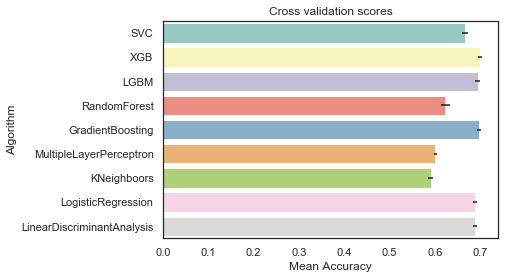

In [43]:
st_time = time.time() 

# append classifier
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(XGBClassifier())
classifiers.append(LGBMClassifier())
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

# Train each model
cv_results = []
for classifier in classifiers :
    start_time = time.time() 
    print(classifier.__class__)
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kfold, n_jobs=-1))
    print("\n--- %s seconds ---" %(round(time.time() - start_time)))

cv_means = []
cv_std = []

# result
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","XGB",'LGBM',"RandomForest","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

# visualization
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

print("\n--- %s seconds ---" %(round(time.time() - st_time)))

In [45]:
cv_res.sort_values('CrossValMeans', ascending=False)

,CrossValMeans,CrossValerrors,Algorithm
1,0.699767,0.004553,XGB
4,0.698102,0.004661,GradientBoosting
2,0.694561,0.005442,LGBM
8,0.688638,0.004108,LinearDiscriminantAnalysis
7,0.688497,0.004668,LogisticRegression
0,0.667052,0.006204,SVC
3,0.623078,0.010345,RandomForest
5,0.601618,0.003364,MultipleLayerPerceptron
6,0.590637,0.006242,KNeighboors


## 4. 본격적인 모델 학습

### 4.1 Xgboost

In [91]:
def train_xgb(train_data, test_data) :
    
    global xgb_best
    global xgb
    
    # start time
    start_time = time.time() 

    # xgboost
    XGB = XGBClassifier(random_state=random_state)

    # search parameter              
    param_grid = {'n_estimators' : [100],'learning_rate': [0.03],
                  'max_depth': [3],'min_child_weight' : [1],
                  'objective' : ['binary:logistic']}

    xgb = GridSearchCV(XGB, param_grid = param_grid, cv = 5, scoring = "accuracy", n_jobs = -1, verbose = 1)

    # train
    xgb.fit(train_data, y_train)

    # best model
    xgb_best = xgb.best_estimator_
    print('* best parameter : {}'.format(xgb.best_estimator_))

    # Best score
    print('* best score : {}'.format(xgb.best_score_))
    
    # score
    pred = xgb.predict_proba(X_train)[:,1]
    score = roc_auc_score(y_train, pred)
    print('* score {}'.format(score))

    # predict
    xgb_pred = xgb_best.predict_proba(test_data)[:,1]

    # time check
    print("\n\n--- %s seconds ---" %(round(time.time() - start_time)))
    
    # return
    return xgb_pred

### 4.2 GBM

In [92]:
def train_gbm(train_data, test_data) :
    
    global gbc_best
    global gbc
    
    # start time
    start_time = time.time() 

    # grid search
    param_grid = {'loss' : ["deviance"],'n_estimators' : [100],'learning_rate': [0.05],
                  'max_depth': [1],'max_features': [3] }

    # Gradient boosting tunning
    GBC = GradientBoostingClassifier()

    # grid search
    gbc = GridSearchCV(GBC, param_grid = param_grid, cv = 5, scoring = "accuracy", n_jobs = -1, verbose = 2)

    # train
    gbc.fit(train_data,y_train)

    # best model
    gbc_best = gbc.best_estimator_
    print('best parameter : {}'.format(gbc.best_estimator_))

    # Best score
    print('best score : {}'.format(gbc.best_score_))
    
    # score
    pred = gbc.predict_proba(X_train)[:,1]
    score = roc_auc_score(y_train, pred)
    print('* score {}'.format(score))    

    # predict
    gbm_pred = gbc_best.predict_proba(test_data)[:,1]

    # time checkb
    print("--- %s seconds ---" %(round(time.time() - start_time)))
    
    return gbm_pred

### 4.3 Light GBM

In [93]:
def train_lgb(train_data, test_data):
    
    global lgbm
    global lgbm_best
    
    # start time
    start_time = time.time() 
    
    # grid search
    param_grid = {'n_estimators' : [1000],'learning_rate': [0.01],
                  'max_depth': [5],'reg_alpha': [0.1],'reg_lambda': [1],'num_leaves' : [15]}
    
    # lgbm
    LGBM = LGBMClassifier()
    
    # model
    lgbm = GridSearchCV(LGBM, param_grid = param_grid, cv = 5, scoring="roc_auc", n_jobs = -1, verbose = 1)

    # train
    lgbm.fit(train_data, y_train)
    
    # Best score
    print('best score : {}'.format(lgbm.best_score_))
    
    # score
    pred = lgbm.predict_proba(X_train)[:,1]
    score = roc_auc_score(y_train, pred)
    print('* score {}'.format(score))        
    
    # pred       
    lgb_pred = lgbm.predict_proba(test_data)[:,1]
    
    # time check
    print("\n\n--- %s seconds ---" %(round(time.time() - start_time)))
    
    return lgb_pred

## 4. Ensemble

In [94]:
def my_ensemble(train_data, test_data) :
    
    # start time
    start_time = time.time()
    
    global xgb_pred
    global gbc_pred
    global lgbm_pred
    
    # xgb
    xgb_pred = train_xgb(train_data, test_data)
    
    # lgbm 
    lgbm_pred = train_lgb(train_data, test_data)
    
    # gbc
    gbc_pred = train_gbm(train_data,test_data)
        
    # ensemble
    pred = (xgb_pred + lgbm_pred + gbc_pred) / 3
    
    # time check
    print("\n\n--- %s seconds ---" %(round(time.time() - start_time)))
    
    return pred

In [95]:
pred = my_ensemble(X_train, X_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


* best parameter : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=1234, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
* best score : 0.7114666666666667
* score 0.7069091384276713


--- 159 seconds ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


best score : 0.7018307455450675
* score 0.7935527210323063


--- 225 seconds ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


best parameter : GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=1,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
best score : 0.6961333333333334
* score 0.6589355674882453
--- 5 seconds ---


--- 388 seconds ---


## 5. Submission

In [49]:
# time check
dt = datetime.today().strftime("%m-%d") ; display(dt)

# test_custid
test_custid = list(range(30000, 49995))

'05-23'

In [50]:
fname = './submission/' + dt + 'pca + xgb.csv'
submissions = pd.concat([pd.Series(test_custid, name="custid"), pd.Series(pred , name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)

print('submission shape : {}'.format(submissions.shape))
print("'{}' is ready to submit." .format(fname))

submission shape : (19995, 2)
'./submission/05-23pca + xgb.csv' is ready to submit.
